In [1]:

from flaxdiff.schedulers import EDMNoiseScheduler, KarrasVENoiseScheduler
from flaxdiff.predictors import KarrasPredictionTransform
from flaxdiff.models.simple_unet import Unet
from flaxdiff.trainer.general_diffusion_trainer import GeneralDiffusionTrainer, ConditionalInputConfig
from flaxdiff.data.dataloaders import get_dataset_grain
from flaxdiff.utils import defaultTextEncodeModel
from flaxdiff.models.autoencoder.diffusers import StableDiffusionVAE
from flaxdiff.samplers.euler import EulerAncestralSampler
import jax
import jax.numpy as jnp
import optax
from datetime import datetime
import argparse
import os

BATCH_SIZE = 16
IMAGE_SIZE = 256

In [2]:
# Load dataset
data = get_dataset_grain(
    "oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SIZE)
datalen = data['train_len']
batches = datalen // BATCH_SIZE

text_encoder = defaultTextEncodeModel()
autoencoder = StableDiffusionVAE(**{"modelname": "pcuenq/sd-vae-ft-mse-flax"})

# Construct a validation set by the prompts
val_prompts = ['water tulip', ' a water lily', ' a water lily', ' a photo of a rose', ' a photo of a rose', ' a water lily', ' a water lily', ' a photo of a marigold', ' a photo of a marigold', ' a photo of a marigold', ' a water lily', ' a photo of a sunflower', ' a photo of a lotus', ' columbine', ' columbine', ' an orchid', ' an orchid', ' an orchid', ' a water lily', ' a water lily', ' a water lily', ' columbine', ' columbine', ' a photo of a sunflower', ' a photo of a sunflower', ' a photo of a sunflower', ' a photo of a lotus', ' a photo of a lotus', ' a photo of a marigold', ' a photo of a marigold', ' a photo of a rose', ' a photo of a rose', ' a photo of a rose',
               ' orange dahlia', ' orange dahlia', ' a lenten rose', ' a lenten rose', ' a water lily', ' a water lily', ' a water lily', ' a water lily', ' an orchid', ' an orchid', ' an orchid', ' hard-leaved pocket orchid', ' bird of paradise', ' bird of paradise', ' a photo of a lovely rose', ' a photo of a lovely rose', ' a photo of a globe-flower', ' a photo of a globe-flower', ' a photo of a lovely rose', ' a photo of a lovely rose', ' a photo of a ruby-lipped cattleya', ' a photo of a ruby-lipped cattleya', ' a photo of a lovely rose', ' a water lily', ' a osteospermum', ' a osteospermum', ' a water lily', ' a water lily', ' a water lily', ' a red rose', ' a red rose']


def get_val_dataset(batch_size=8):
    for i in range(0, len(val_prompts), batch_size):
        prompts = val_prompts[i:i + batch_size]
        tokens = text_encoder.tokenize(prompts)
        yield {"text": tokens}


data['test'] = get_val_dataset
data['test_len'] = len(val_prompts)

2025-04-18 23:34:16.627362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745019256.650264 1938680 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745019256.657332 1938680 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745019256.673689 1938680 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745019256.673706 1938680 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745019256.673708 1938680 computation_placer.cc:177] computation placer alr

Scaling factor: 0.18215
Calculating downscale factor...
Downscale factor: 8
Latent channels: 4


In [7]:
from flax import linen as nn
from diffusers import FlaxUNet2DConditionModel
from flaxdiff.inputs import DiffusionInputConfig, ConditionalInputConfig

input_config = DiffusionInputConfig(
    sample_data_key='image',
    sample_data_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    conditions=[
        ConditionalInputConfig(
            encoder=text_encoder,
            conditioning_data_key='text',
            pretokenized=True,
            unconditional_input="",
            model_key_override="textcontext",
        )
    ],
)

input_shapes = input_config.get_input_shapes(
    autoencoder=autoencoder,
)

unet_model = FlaxUNet2DConditionModel(
    sample_size=input_shapes["x"][1],  # the target image resolution
    # the number of input channels, 3 for RGB images
    in_channels=input_shapes["x"][2],
    out_channels=input_shapes["x"][2],  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    # the number of output channels for each UNet block
    block_out_channels=(64, 128, 256, 512),
    cross_attention_dim=512,  # the size of the cross-attention layers
    dtype=jnp.bfloat16,
    use_memory_efficient_attention=True,
)


class BCHWModelWrapper(nn.Module):
    model: nn.Module

    @nn.compact
    def __call__(self, x, temb, textcontext):
        # Reshape the input to BCHW format from BHWC
        x = jnp.transpose(x, (0, 3, 1, 2))
        # Pass the input through the UNet model
        out = self.model(
            sample=x,
            timesteps=temb,
            encoder_hidden_states=textcontext,
        )
        # Reshape the output back to BHWC format
        out = jnp.transpose(out.sample, (0, 2, 3, 1))
        return out
    
    @property
    def __dict__(self):
        return self.model.__dict__

unet = BCHWModelWrapper(unet_model)

Calculated input shapes: {'x': (32, 32, 4), 'temb': (), 'textcontext': (77, 768)}


In [3]:
from flaxdiff.inputs import DiffusionInputConfig, ConditionalInputConfig

input_config = DiffusionInputConfig(
    sample_data_key='image',
    sample_data_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    conditions=[
        ConditionalInputConfig(
            encoder=text_encoder,
            conditioning_data_key='text',
            pretokenized=True,
            unconditional_input="",
            model_key_override="textcontext",
        )
    ]
)

input_shapes = input_config.get_input_shapes(
    autoencoder=autoencoder,
)

unet = Unet(emb_features=256,
            feature_depths=[64, 64, 128, 256, 512],
            attention_configs=[
                None,
                {"heads": 8, "dtype": jnp.float32, "flash_attention": False,
                    "use_projection": False, "use_self_and_cross": True},
                {"heads": 8, "dtype": jnp.float32, "flash_attention": False,
                    "use_projection": False, "use_self_and_cross": True},
                {"heads": 8, "dtype": jnp.float32, "flash_attention": False,
                    "use_projection": False, "use_self_and_cross": True},
                {"heads": 8, "dtype": jnp.float32, "flash_attention": False,
                    "use_projection": False, "use_self_and_cross": False}
            ],
            num_res_blocks=2,
            num_middle_res_blocks=1,
            dtype=jnp.bfloat16,
            output_channels=input_shapes["x"][2],
    )

Calculated input shapes: {'x': (32, 32, 4), 'temb': (), 'textcontext': (77, 768)}


In [4]:
# Define noise scheduler
edm_schedule = EDMNoiseScheduler(1, sigma_max=80, rho=7, sigma_data=0.5)
karas_ve_schedule = KarrasVENoiseScheduler(
    1, sigma_max=80, rho=7, sigma_data=0.5)
# Define model

# Define optimizer
solver = optax.adam(2e-4)

# Create the GeneralDiffusionTrainer
experiment_name = "General_Diffusion_demo_for_inference"#f"General_Diffusion_{datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}"

trainer = GeneralDiffusionTrainer(
    unet,
    optimizer=solver,
    noise_schedule=edm_schedule,
    autoencoder=autoencoder,
    input_config=input_config,
    rngs=jax.random.PRNGKey(42),
    name=experiment_name,
    model_output_transform=KarrasPredictionTransform(
        sigma_data=edm_schedule.sigma_data),
    # data_key='image',  # Specify the key for image data in batches
    distributed_training=True,
    wandb_config={
        "project": 'mlops-msml605-project',
        "entity": 'umd-projects',
        "name": experiment_name,
        "config": {
            "batch_size": BATCH_SIZE,
            "image_size": IMAGE_SIZE,
            "architecture": "unet",
        }
    },
    native_resolution=IMAGE_SIZE,
    # Path to the checkpoint
    load_from_checkpoint="/home/mrwhite0racle/persist/FlaxDiff/checkpoints/general_diffusion_2025-04-18_06:34:50",
)

Calculated input shapes: {'x': (32, 32, 4), 'temb': (), 'textcontext': (77, 768)}


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ashishkumar4 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Loading model from checkpoint at step  411355
Loaded model from checkpoint at epoch 804 step 411355 0.4702588
Generating states for DiffusionTrainer


In [ ]:
# Train the model
final_state = trainer.fit(data, batches, epochs=2000,
                          sampler_class=EulerAncestralSampler, sampling_noise_schedule=karas_ve_schedule)

		Epoch 897: 600step [00:31, 19.01step/s, loss=0.4680]                                              

Epoch done on index 0 => 897 Loss: 0.47235533595085144
Epoch done on process index 0

	Epoch 897 completed. Avg Loss: 0.47235533595085144, Time: 31.57s, Best Loss: 0.47025880217552185
Validation started for process index 0



100%|██████████| 200/200 [00:01<00:00, 105.60it/s]


Validation done on process index 0

Epoch 898/2000


		Epoch 898:   0%|                                           | 0/511 [00:00<?, ?step/s, loss=0.4724]

First batch loaded at step 458878
Training started for process index 0 at step 458878


		Epoch 898: 600step [00:30, 19.66step/s, loss=0.4214]                                              

Epoch done on index 0 => 898 Loss: 0.4722280502319336
Epoch done on process index 0

	Epoch 898 completed. Avg Loss: 0.4722280502319336, Time: 30.52s, Best Loss: 0.47025880217552185
Validation started for process index 0



100%|██████████| 200/200 [00:01<00:00, 104.79it/s]


Validation done on process index 0

Epoch 899/2000


		Epoch 899:   0%|                                           | 0/511 [00:00<?, ?step/s, loss=0.4720]

First batch loaded at step 459389
Training started for process index 0 at step 459389


		Epoch 899: 600step [00:30, 19.51step/s, loss=0.5028]                                              

Epoch done on index 0 => 899 Loss: 0.473550945520401
Epoch done on process index 0

	Epoch 899 completed. Avg Loss: 0.473550945520401, Time: 30.75s, Best Loss: 0.47025880217552185
Validation started for process index 0



100%|██████████| 200/200 [00:01<00:00, 104.55it/s]


Validation done on process index 0

Epoch 900/2000


		Epoch 900:   0%|                                           | 0/511 [00:00<?, ?step/s, loss=0.5043]

First batch loaded at step 459900
Training started for process index 0 at step 459900


		Epoch 900: 600step [00:30, 19.69step/s, loss=0.4644]                                              

Epoch done on index 0 => 900 Loss: 0.47377240657806396
Epoch done on process index 0

	Epoch 900 completed. Avg Loss: 0.47377240657806396, Time: 30.48s, Best Loss: 0.47025880217552185
Validation started for process index 0



100%|██████████| 200/200 [00:01<00:00, 101.77it/s]


Validation done on process index 0

Epoch 901/2000


		Epoch 901:   0%|                                           | 0/511 [00:00<?, ?step/s, loss=0.4685]

First batch loaded at step 460411
Training started for process index 0 at step 460411


		Epoch 901: 600step [00:31, 19.08step/s, loss=0.4860]                                              

Epoch done on index 0 => 901 Loss: 0.47391751408576965
Epoch done on process index 0

	Epoch 901 completed. Avg Loss: 0.47391751408576965, Time: 31.45s, Best Loss: 0.47025880217552185
Validation started for process index 0



100%|██████████| 200/200 [00:01<00:00, 100.14it/s]


Validation done on process index 0

Epoch 902/2000


		Epoch 902:   0%|                                           | 0/511 [00:00<?, ?step/s, loss=0.4568]

First batch loaded at step 460922
Training started for process index 0 at step 460922


		Epoch 902: 600step [00:31, 18.90step/s, loss=0.4688]                                              

Epoch done on index 0 => 902 Loss: 0.47201600670814514
Epoch done on process index 0

	Epoch 902 completed. Avg Loss: 0.47201600670814514, Time: 31.75s, Best Loss: 0.47025880217552185
Validation started for process index 0



100%|██████████| 200/200 [00:01<00:00, 100.31it/s]


Validation done on process index 0

Epoch 903/2000


		Epoch 903:   0%|                                           | 0/511 [00:00<?, ?step/s, loss=0.4279]

First batch loaded at step 461433
Training started for process index 0 at step 461433


Process SpawnProcess-29:
Process SpawnProcess-32:
Process SpawnProcess-15:
Process SpawnProcess-18:
Process SpawnProcess-10:
Process SpawnProcess-31:
Process SpawnProcess-21:
Process SpawnProcess-6:
Process SpawnProcess-16:
Process SpawnProcess-27:
Process SpawnProcess-9:
Process SpawnProcess-4:
Process SpawnProcess-25:
Process SpawnProcess-7:
Process SpawnProcess-23:
Process SpawnProcess-11:
Process SpawnProcess-28:
Process SpawnProcess-12:
Process SpawnProcess-30:
Process SpawnProcess-19:
Process SpawnProcess-2:
Process SpawnProcess-5:
Process SpawnProcess-8:
Process SpawnProcess-14:
Process SpawnProcess-24:
Process SpawnProcess-26:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceba

KeyboardInterrupt: 

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f734c1c4290>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f726c109890, execution_count=5 error_before_exec=None error_in_exec= info=<ExecutionInfo object at 7f70ac1bd0d0, raw_cell="# Train the model
final_state = trainer.fit(data, .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Btpu-v4-8/home/mrwhite0racle/persist/FlaxDiff/prototype_general_pipeline.ipynb#W5sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


MailboxClosedError: 

In [5]:
import matplotlib.pyplot as plt


def normalizeImage(x): return jax.nn.standardize(x, mean=[127.5], std=[127.5])
def denormalizeImage(x): return (x + 1.0) * 127.5


def plotImages(imgs, fig_size=(8, 8), dpi=100):
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    imglen = imgs.shape[0]
    for i in range(imglen):
        plt.subplot(fig_size[0], fig_size[1], i + 1)
        plt.imshow(jnp.astype(denormalizeImage(imgs[i, :, :, :]), jnp.uint8))
        plt.axis("off")
    plt.show()

In [6]:
sampler = EulerAncestralSampler(
    model=trainer.model,
    noise_schedule=karas_ve_schedule,
    model_output_transform=KarrasPredictionTransform(
        sigma_data=karas_ve_schedule.sigma_data),
    autoencoder=trainer.autoencoder,
    input_config=trainer.input_config,
    guidance_scale=3,
    timestep_spacing="linear"
)

Using classifier-free guidance


In [7]:
prompts = [
    'water tulip',
    'a water lily',
    'a water lily',
    'a photo of a rose',
    'a photo of a rose',
    'a water lily',
    'a water lily',
    'a photo of a marigold',
]
images = sampler.generate_samples(
    params=trainer.best_state.params,
    resolution=IMAGE_SIZE,
    num_samples=len(prompts),
    sequence_length=None,
    diffusion_steps=200,
    start_step=1000,
    end_step=0,
    conditioning=prompts,
    # model_conditioning_inputs=(encoded,)
)

Processing raw conditioning inputs to generate model conditioning inputs


100%|██████████| 200/200 [00:15<00:00, 13.01it/s]


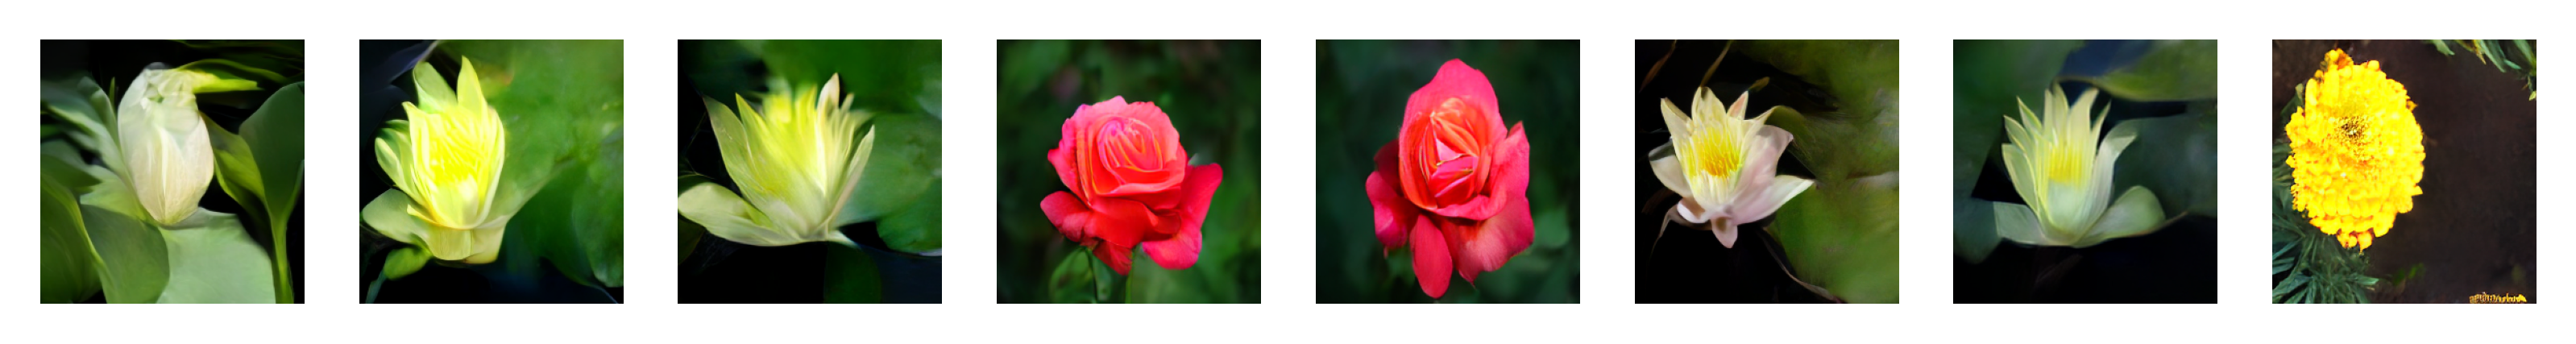

In [8]:
plotImages(images, dpi=500)

In [8]:
run = trainer.wandb

In [9]:
checkpoint_path = "/home/mrwhite0racle/persist/FlaxDiff/checkpoints/general_diffusion_2025-04-18_06:34:50"
# Find the latest checkpoint step
# List directory contents

def get_latest_checkpoint(checkpoint_path):
    checkpoint_files = os.listdir(checkpoint_path)
    # Sort files by step number
    checkpoint_files = sorted([int(i) for i in checkpoint_files])
    latest_step = checkpoint_files[-1]
    latest_checkpoint = os.path.join(checkpoint_path, str(latest_step))
    return latest_checkpoint

In [10]:
# Log the artifact to W&B
logged_artifact = run.log_artifact(
    artifact_or_path=get_latest_checkpoint(checkpoint_path),
    name='diffusion-experimental-oxford-vae',
    type="model"
)

run.link_artifact(
    artifact=logged_artifact,
    target_path="umd-projects-org/wandb-registry-model/diffusion-experimental-oxford-vae"
)

wandb: Adding directory to artifact (/home/mrwhite0racle/persist/FlaxDiff/checkpoints/general_diffusion_2025-04-18_06:34:50/411355)... Done. 9.0s
